In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


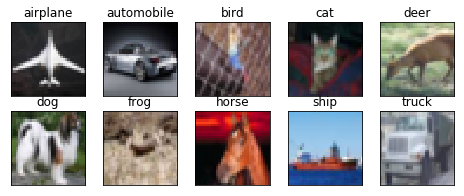

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
from keras.layers import Input
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.layers.merge import add,concatenate
import keras
from keras.models import Model

In [43]:

input_shape=(32, 32, 3)
input = Input(shape=input_shape)

sep_1 =keras.layers.SeparableConv2D(32, (5,5), strides=(1, 1), padding='same', data_format=None, 
                                       dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=True, 
                                       depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
                                       bias_initializer='zeros', depthwise_regularizer=None, pointwise_regularizer=None, bias_regularizer=None,
                                       activity_regularizer=None, depthwise_constraint=None, pointwise_constraint=None, bias_constraint=None)(input)
sep_1 = (BatchNormalization())(sep_1)
sep_1 = (Activation('relu'))(sep_1)

con_1 = (Convolution2D(64, 5,5, border_mode='same'))(sep_1)
con_1 = (BatchNormalization())(con_1)
con_1 = (Activation('relu'))(con_1)

con_2 = (Convolution2D(128, 5,5, border_mode='same'))(con_1)
con_2 = (BatchNormalization())(con_2)
con_2 = (Activation('relu'))(con_2)

concat_1 = concatenate([sep_1,con_2])

sep_2 =keras.layers.SeparableConv2D(256, (5,5), strides=(1, 1), padding='same', data_format=None, 
                                       dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=True, 
                                       depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
                                       bias_initializer='zeros', depthwise_regularizer=None, pointwise_regularizer=None, bias_regularizer=None,
                                       activity_regularizer=None, depthwise_constraint=None, pointwise_constraint=None, bias_constraint=None)(concat_1)
sep_2 = (BatchNormalization())(sep_2)
sep_2 = (Activation('relu'))(sep_2)

concat_2 = concatenate([sep_2,sep_1])

max_1 = MaxPooling2D(pool_size=(2, 2))(concat_2)

sep_3 =keras.layers.SeparableConv2D(32, (3,3), strides=(1, 1), padding='same', data_format=None, 
                                       dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=True, 
                                       depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
                                       bias_initializer='zeros', depthwise_regularizer=None, pointwise_regularizer=None, bias_regularizer=None,
                                       activity_regularizer=None, depthwise_constraint=None, pointwise_constraint=None, bias_constraint=None)(max_1)
sep_3 = (BatchNormalization())(sep_3)
sep_3 = (Activation('relu'))(sep_3)

concat_3_1 = concatenate([sep_2,sep_1])
concat_3_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_3_1)
concat_3 = concatenate([sep_3,concat_3_1])

con_3 = (Convolution2D(64, 5,5, border_mode='same'))(concat_3)
con_3 = (BatchNormalization())(con_3)
con_3 = (Activation('relu'))(con_3)


concat_4_1 = concatenate([sep_2,con_2])
concat_4_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_4_1)
concat_4 = concatenate([con_3,sep_3,concat_4_1])

sep_4 =keras.layers.SeparableConv2D(128, (3,3), strides=(1, 1), padding='same', data_format=None, 
                                       dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=True, 
                                       depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
                                       bias_initializer='zeros', depthwise_regularizer=None, pointwise_regularizer=None, bias_regularizer=None,
                                       activity_regularizer=None, depthwise_constraint=None, pointwise_constraint=None, bias_constraint=None)(concat_4)
sep_4 = (BatchNormalization())(sep_4)
sep_4 = (Activation('relu'))(sep_4)


concat_5_1 = concatenate([sep_2,con_2])
concat_5_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_5_1)
concat_5 = concatenate([con_3,sep_3,sep_4,concat_5_1])
sep_5 =keras.layers.SeparableConv2D(256, (5,5), strides=(1, 1), padding='same', data_format=None, 
                                       dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=True, 
                                       depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
                                       bias_initializer='zeros', depthwise_regularizer=None, pointwise_regularizer=None, bias_regularizer=None,
                                       activity_regularizer=None, depthwise_constraint=None, pointwise_constraint=None, bias_constraint=None)(concat_5)
sep_5 = (BatchNormalization())(sep_5)
sep_5 = (Activation('relu'))(sep_5)

concat_6_1 = concatenate([sep_2,con_2])
concat_6_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_6_1)

concat_6 = concatenate([sep_3,sep_4,sep_5,concat_6_1])
max_2 = MaxPooling2D(pool_size=(2, 2))(concat_6)

# concat_7_1 = concatenate([sep_2,con_2])
concat_7_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(con_3)
concat_7 = concatenate([concat_7_1,max_2])
con_4 = (Convolution2D(32, 5,5, border_mode='same'))(concat_7)
con_4 = (BatchNormalization())(con_4)
con_4 = (Activation('relu'))(con_4)


concat_8_1 = concatenate([sep_2,con_2])
concat_8_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(con_1)

concat_8_2 = concatenate([concat_8_1,sep_4])
concat_8_2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_8_2)
concat_8 = concatenate([con_4,concat_8_2])

sep_6 =keras.layers.SeparableConv2D(64, (5,5), strides=(1, 1), padding='same', data_format=None, 
                                       dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=True, 
                                       depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
                                       bias_initializer='zeros', depthwise_regularizer=None, pointwise_regularizer=None, bias_regularizer=None,
                                       activity_regularizer=None, depthwise_constraint=None, pointwise_constraint=None, bias_constraint=None)(concat_8)
sep_6 = (BatchNormalization())(sep_6)
sep_6 = (Activation('relu'))(sep_6)


concat_9_1 = concatenate([con_2,con_1])
concat_9_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_9_1)

concat_9_2 = concatenate([concat_9_1,sep_3])
concat_9_2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_9_2)

concat_9 = concatenate([concat_9_2,con_4,sep_6])
con_5 = (Convolution2D(128, 3,3, border_mode='same'))(concat_9)
con_5 = (BatchNormalization())(con_5)
con_5 = (Activation('relu'))(con_5)

concat_10_1 = concatenate([con_2,sep_2,sep_1,con_1])
concat_10_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_10_1)

concat_10_2 = concatenate([concat_10_1,sep_3,sep_4])
concat_10_2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_10_2)

concat_10 = concatenate([concat_10_2,sep_6,con_5]) 
sep_7 =keras.layers.SeparableConv2D(256, (5,5), strides=(1, 1), padding='same', data_format=None, 
                                       dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=True, 
                                       depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
                                       bias_initializer='zeros', depthwise_regularizer=None, pointwise_regularizer=None, bias_regularizer=None,
                                       activity_regularizer=None, depthwise_constraint=None, pointwise_constraint=None, bias_constraint=None)(concat_10)
sep_7 = (BatchNormalization())(sep_7)
sep_7 = (Activation('relu'))(sep_7)



concat_11_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(sep_2)
concat_11_2 = concatenate([concat_11_1,sep_3,sep_4])
concat_11_2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_11_2)

concat_11 = concatenate([sep_6,sep_7,concat_11_2])
#flat_1 = Flatten()(con_5)
con_point_1 = (Convolution2D(10, 1,1, border_mode='same'))(concat_11)

flat_1 = keras.layers.GlobalAveragePooling2D(data_format=None)(con_point_1)

softmax = Activation('softmax') (flat_1)


model = Model(inputs=input, outputs=softmax)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:140: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), padding="same")`


In [44]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_88 (SeparableC (None, 32, 32, 32)   203         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 32, 32, 32)   128         separable_conv2d_88[0][0]        
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 32, 32, 32)   0           batch_normalization_37[0][0]     
__________________________________________________________________________________________________
conv2d_71 

In [0]:
from keras.utils import plot_model
plot = plot_model(model,to_file='/content/gdrive/My Drive/Colab Notebooks/EVA/7/model_concat.png')


In [0]:
# import cv2
# model_plot = cv2.imread('/content/gdrive/My Drive/Colab Notebooks/EVA/6/model.png')



In [0]:
# import matplotlib.pyplot as plt
# plt.imshow(model_plot)

In [47]:
from keras.callbacks import  ModelCheckpoint

filepath="/content/gdrive/My Drive/Colab Notebooks/EVA/7/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
#file path store weights in google drive

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# Store the weights when the validation accuracy increases

from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
  return round(0.002 * 1/(1 + 0.119 * epoch), 10)


from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=.25, 
                             featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,                           
                             vertical_flip=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 #callbacks=[checkpoint],#,LearningRateScheduler(scheduler, verbose=1)],
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=195, epochs=100)`


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


195/195 [==============================] - 89s 458ms/step - loss: 1.6867 - acc: 0.3852 - val_loss: 2.6941 - val_acc: 0.2998
Epoch 2/100
195/195 [==============================] - 83s 426ms/step - loss: 1.3899 - acc: 0.4993 - val_loss: 2.6290 - val_acc: 0.3442
Epoch 3/100
195/195 [==============================] - 83s 426ms/step - loss: 1.2277 - acc: 0.5606 - val_loss: 2.9590 - val_acc: 0.3297
Epoch 4/100
195/195 [==============================] - 83s 428ms/step - loss: 1.1236 - acc: 0.5973 - val_loss: 1.3511 - val_acc: 0.5481
Epoch 5/100
195/195 [==============================] - 84s 429ms/step - loss: 1.0285 - acc: 0.6336 - val_loss: 2.3568 - val_acc: 0.3947
Epoch 6/100
195/195 [==============================] - 84s 429ms/step - loss: 0.9510 - acc: 0.6636 - val_loss: 1.6171 - val_acc: 0.5042
Epoch 7/100
195/195 [==============================] - 84s 429ms/step - loss: 0.8964 - acc: 0.6821 - val_loss: 0.9225 - val_acc: 0.6842
Epoch 8/100
195/195 [==============================] - 84s 4

Model took 8367.20 seconds to train


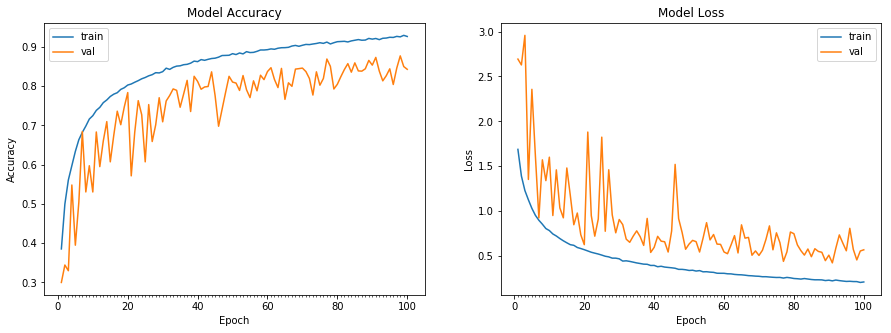

Accuracy on test data is: 84.29


In [48]:
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [49]:
# model.load_weights('/content/gdrive/My Drive/Colab Notebooks/EVA/6/epochs:072-val_acc:0.842.hdf5')

# model.compile(loss='categorical_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])

score = model.evaluate(test_features, test_labels)#, steps = 10,verbose=0)
print(score[1])

10000/10000 [==============================] - 6s 571us/step
0.8429


In [50]:
print(score[1])

0.8429


In [0]:

# input_shape=(32, 32, 3)
# input = Input(shape=input_shape)

# sep_1 =keras.layers.SeparableConv2D(32, (5,5), strides=(1, 1), padding='same', data_format=None, 
#                                        dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=True, 
#                                        depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
#                                        bias_initializer='zeros', depthwise_regularizer=None, pointwise_regularizer=None, bias_regularizer=None,
#                                        activity_regularizer=None, depthwise_constraint=None, pointwise_constraint=None, bias_constraint=None)(input)

# con_1 = (Convolution2D(32, 5,5, border_mode='same'))(sep_1)

# con_2 = (Convolution2D(64, 5,5, border_mode='same'))(con_1)

# concat_1 = add([sep_1,con_2])

# sep_2 =keras.layers.SeparableConv2D(64, (5,5), strides=(1, 1), padding='same', data_format=None, 
#                                        dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=True, 
#                                        depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
#                                        bias_initializer='zeros', depthwise_regularizer=None, pointwise_regularizer=None, bias_regularizer=None,
#                                        activity_regularizer=None, depthwise_constraint=None, pointwise_constraint=None, bias_constraint=None)(concat_1)


# concat_2 = add([sep_2,sep_1])

# max_1 = MaxPooling2D(pool_size=(2, 2))(concat_2)

# sep_3 =keras.layers.SeparableConv2D(64, (3,3), strides=(1, 1), padding='same', data_format=None, 
#                                        dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=True, 
#                                        depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
#                                        bias_initializer='zeros', depthwise_regularizer=None, pointwise_regularizer=None, bias_regularizer=None,
#                                        activity_regularizer=None, depthwise_constraint=None, pointwise_constraint=None, bias_constraint=None)(max_1)

# concat_3_1 = add([sep_2,sep_1])
# concat_3_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_3_1)
# concat_3 = add([sep_3,concat_3_1])

# con_3 = (Convolution2D(64, 5,5, border_mode='same'))(concat_3)


# concat_4_1 = add([sep_2,con_2])
# concat_4_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_4_1)
# concat_4 = add([con_3,sep_3,concat_4_1])

# sep_4 =keras.layers.SeparableConv2D(64, (3,3), strides=(1, 1), padding='same', data_format=None, 
#                                        dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=True, 
#                                        depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
#                                        bias_initializer='zeros', depthwise_regularizer=None, pointwise_regularizer=None, bias_regularizer=None,
#                                        activity_regularizer=None, depthwise_constraint=None, pointwise_constraint=None, bias_constraint=None)(concat_4)

# concat_5_1 = concatenate([sep_2,con_2])
# concat_5_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_5_1)
# concat_5 = add([con_3,sep_3,sep_4,concat_5_1])
# sep_5 =keras.layers.SeparableConv2D(64, (5,5), strides=(1, 1), padding='same', data_format=None, 
#                                        dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=True, 
#                                        depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
#                                        bias_initializer='zeros', depthwise_regularizer=None, pointwise_regularizer=None, bias_regularizer=None,
#                                        activity_regularizer=None, depthwise_constraint=None, pointwise_constraint=None, bias_constraint=None)(concat_5)

# concat_6_1 = concatenate([sep_2,con_2])
# concat_6_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_6_1)

# concat_6 = add([sep_3,sep_4,sep_5,concat_6_1])
# max_2 = MaxPooling2D(pool_size=(2, 2))(concat_6)

# # concat_7_1 = concatenate([sep_2,con_2])
# concat_7_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(con_3)
# concat_7 = add([concat_7_1,max_2])
# con_4 = (Convolution2D(64, 5,5, border_mode='same'))(concat_7)


# concat_8_1 = add([sep_2,con_2])
# concat_8_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(con_1)

# concat_8_2 = add([concat_8_1,sep_4])
# concat_8_2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_8_2)
# concat_8 = add([con_4,concat_8_2])

# sep_6 =keras.layers.SeparableConv2D(64, (5,5), strides=(1, 1), padding='same', data_format=None, 
#                                        dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=True, 
#                                        depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
#                                        bias_initializer='zeros', depthwise_regularizer=None, pointwise_regularizer=None, bias_regularizer=None,
#                                        activity_regularizer=None, depthwise_constraint=None, pointwise_constraint=None, bias_constraint=None)(concat_8)


# concat_9_1 = add([con_2,con_1])
# concat_9_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_9_1)

# concat_9_2 = add([concat_9_1,sep_3])
# concat_9_2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_9_2)

# concat_9 = add([concat_9_2,con_4,sep_6])
# con_5 = (Convolution2D(64, 3,3, border_mode='same'))(concat_9)

# concat_10_1 = add([con_2,sep_2,sep_1,con_1])
# concat_10_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_10_1)

# concat_10_2 = add([concat_10_1,sep_3,sep_4])
# concat_10_2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_10_2)

# concat_10 = add([concat_10_2,sep_6,con_5]) 
# sep_7 =keras.layers.SeparableConv2D(64, (5,5), strides=(1, 1), padding='same', data_format=None, 
#                                        dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=True, 
#                                        depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform',
#                                        bias_initializer='zeros', depthwise_regularizer=None, pointwise_regularizer=None, bias_regularizer=None,
#                                        activity_regularizer=None, depthwise_constraint=None, pointwise_constraint=None, bias_constraint=None)(concat_10)



# concat_11_1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(sep_2)
# concat_11_2 = add([concat_11_1,sep_3,sep_4])
# concat_11_2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(concat_11_2)

# concat_11 = add([sep_6,sep_7,concat_11_2])
# #flat_1 = Flatten()(con_5)

# flat_1 = keras.layers.GlobalAveragePooling2D(data_format=None)(concat_11)

# softmax = Activation('softmax') (flat_1)


# model = Model(inputs=input, outputs=softmax)

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])